# Hello autoencoder on FashionMNIST dataset

In [2]:
# Prerequisites
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

print("Python Version: ", sys.version)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


### Get FashionMNIST Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

Preprocess Data

In [4]:
def data_preprocess(images):
    # Normalize the images to [0, 1] and convert to float32
    images = images.astype('float32') / 255.0
    # Pad from 28x28 to 32x32
    images = np.pad(images, ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0.0)
    # Add channel Dimension
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    return images

In [5]:
x_train = data_preprocess(x_train)
x_test = data_preprocess(x_test)

In [14]:
# Helper function to display images
def display_images(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    """
    Display n images from array
    """
    # Check that images are scaled to [0, 1] to be compatible with plt.imshow
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    plt.show()

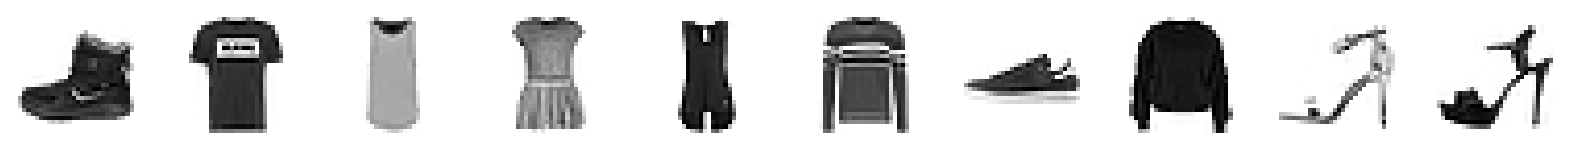

In [15]:
display_images(x_train)


### Build the Encoder

In [8]:
EMBEDDING_DIM = 2  # Dimension of the embedding space

# Define the Encoder model
enc_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(enc_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_b4_flattening = K.int_shape(x)[1:]  # Needed for the decoder

x = layers.Flatten()(x)
enc_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(enc_input, enc_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

### Build the Decoder

In [9]:
# Define the decoder model
dec_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_b4_flattening))(dec_input)
x = layers.Reshape(shape_b4_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
dec_output = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder = models.Model(dec_input, dec_output)
decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### Join the Encoder to the Decoder

In [10]:
autoencoder = models.Model(enc_input, decoder(enc_output)) 

autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Autoencoder

In [11]:
# Compile
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [12]:
# Train
autoencoder.fit(x_train, x_train, epochs=5, batch_size=100, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.3591 - val_loss: 0.2610
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.2584 - val_loss: 0.2570
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.2543 - val_loss: 0.2548
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.2524 - val_loss: 0.2530
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.2511 - val_loss: 0.2515


### Reconstruct Test Images and compare to original

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Example images:


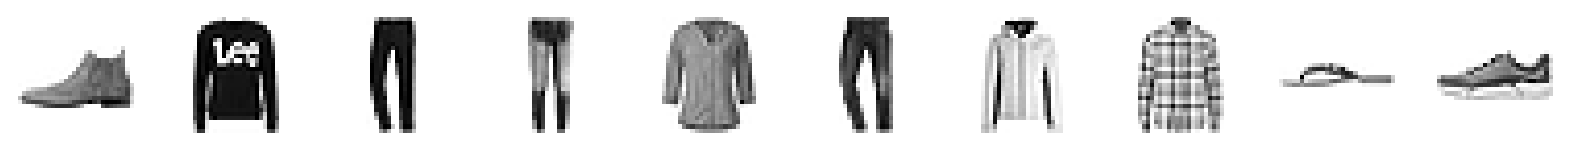

Autoencode Reconstructions:


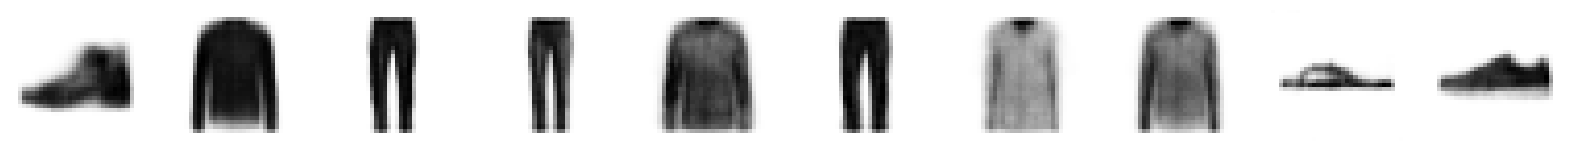

In [17]:
example_images = x_test[:1000]
example_labels = y_test[:1000]

predictions = autoencoder.predict(example_images)

print("Example images:")
display_images(example_images)
print("Autoencode Reconstructions:")
display_images(predictions)

### Visualized Embedding in the latent space

In [18]:
# Encode example images
embeddings = encoder.predict(example_images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [20]:
# Check out sample embeddings
print(embeddings[:5])

[[ 0.01916598  2.080379  ]
 [ 5.1115065  -0.5289213 ]
 [ 0.05248957 -5.35101   ]
 [-0.3439383  -3.1947534 ]
 [ 2.807876    0.06550536]]


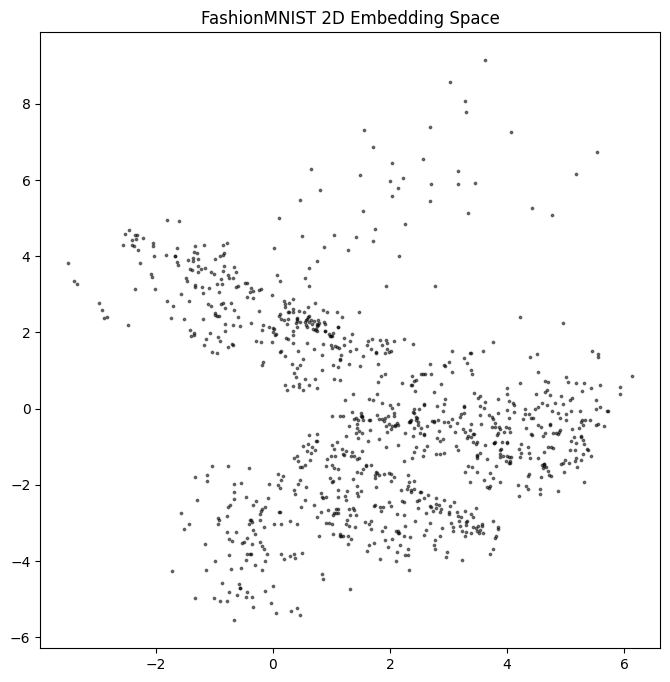

In [24]:
# Visualize Embeddings in 2D space
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.title("FashionMNIST 2D Embedding Space")
plt.show()

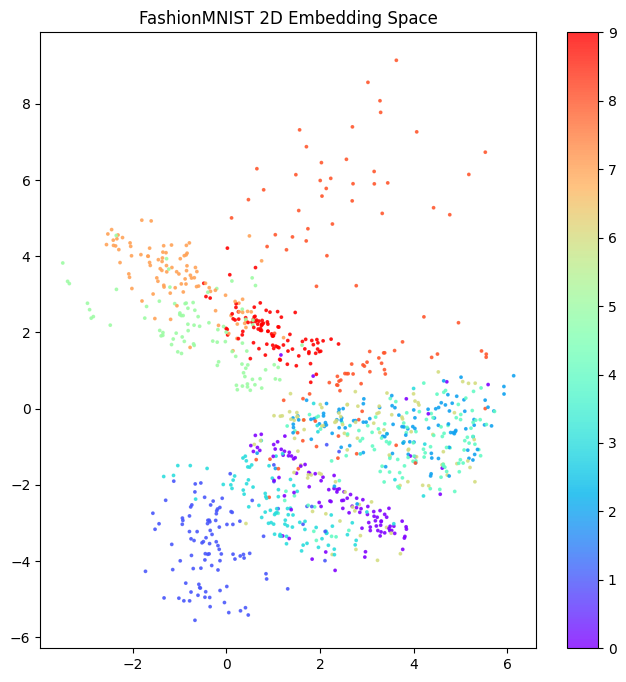

In [25]:
# Color embeddings by class
example_labels = y_test[:1000]

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.title("FashionMNIST 2D Embedding Space")
plt.colorbar()
plt.show()

### Generate new images with Decoder

In [26]:
# Generate sample points in the embedding (latent) space
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, 2))

In [27]:
# Decode sample points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Show points in Embedding space and the corresponding generated images

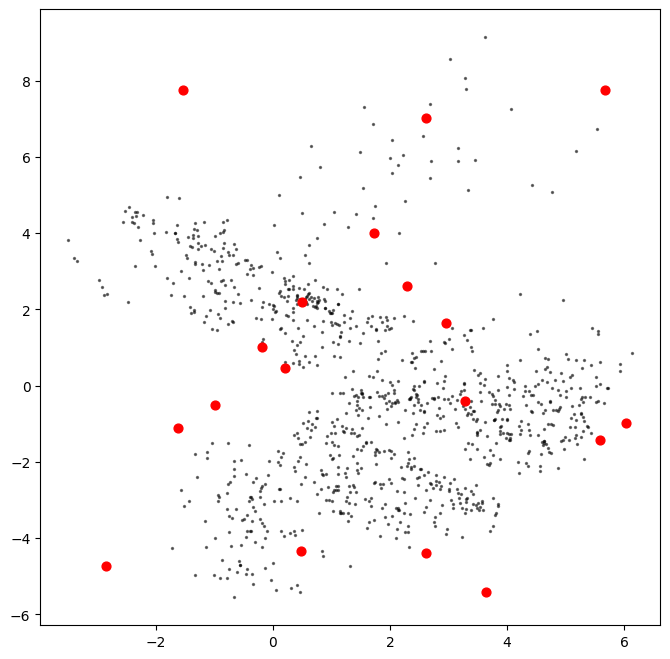

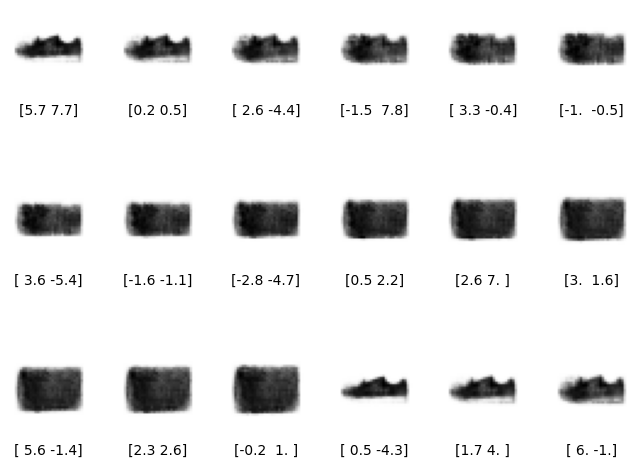

In [31]:

plt.figure(figsize=(8, 8))

# Original embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# New Sample point
plt.scatter(sample[:, 0], sample[:, 1], c="red", alpha=1, s=40)
plt.show()

# Show generated images
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap="Greys")